## Step 1 — Definitions and Excel-Parity Targets

We will recreate the Excel analysis in Python using the same business rules and time logic.

**Core metric**
- Sales Order → Dispatch Time (days) = `wh_dispatch_date - so_creation_date` (calendar days)

**Cycle stock**
- Move Codes: 1, 2, 3

**Seasonality**
- Seasonal window: January and February only
- Deseasonalized yearly averages exclude January and February (note: 2025 will be partial-year if only March is available)

**Improvement calculation (lower is better)**
- Improvement % = (Baseline − Current) / Baseline


In [1]:
import pandas as pd

# --- Excel parity targets (from your pasted tables) ---

cycle_stock_yearly_expected = pd.DataFrame(
    {
        "MC1 Avg": [0.928, 0.661, 0.797],
        "MC2 Avg": [1.366, 1.474, 0.705],
        "MC3 Avg": [1.863, 2.618, 1.061],
        "Avg":     [1.386, 1.584, 0.854],
    },
    index=pd.Index([2023, 2024, 2025], name="Year")
)

improvement_2024_vs_2023_expected = pd.Series(
    [0.288, -0.079, -0.405, -0.143],  # as decimals
    index=["MC1", "MC2", "MC3", "Avg"],
    name="2024_vs_2023"
)

improvement_2025_vs_2024_expected = pd.Series(
    [-0.206, 0.522, 0.595, 0.461],
    index=["MC1", "MC2", "MC3", "Avg"],
    name="2025_vs_2024"
)

improvement_2025_vs_2023_expected = pd.Series(
    [0.142, 0.484, 0.431, 0.384],
    index=["MC1", "MC2", "MC3", "Avg"],
    name="2025_vs_2023"
)

deseasonalized_expected = pd.DataFrame(
    {
        "MC1 Avg": [0.77, 0.41, 0.67],
        "MC2 Avg": [1.28, 1.12, 0.54],
        "MC3 Avg": [1.87, 2.38, 0.62],
        "Yr Avg":  [1.30, 1.30, 0.61],
    },
    index=pd.Index([2023, 2024, 2025], name="Year")
)

deseasonalized_improvement_2025_vs_2023_expected = pd.Series(
    [0.123, 0.579, 0.668, 0.532],
    index=["MC1", "MC2", "MC3", "Yr Avg"],
    name="Deseasonalized_2025_vs_2023"
)

seasonal_jan_feb_expected = pd.DataFrame(
    {
        "MC1 Avg": [1.74, 1.92, 0.86],
        "MC2 Avg": [1.82, 3.23, 0.79],
        "MC3 Avg": [1.84, 3.81, 1.28],
        "Yr Avg":  [1.80, 2.99, 0.98],
    },
    index=pd.Index([2023, 2024, 2025], name="Year")
)

seasonal_improvement_2025_vs_2023_expected = pd.Series(
    [0.507, 0.566, 0.304, 0.458],
    index=["MC1", "MC2", "MC3", "Yr Avg"],
    name="Seasonal_2025_vs_2023"
)

seasonal_improvement_2025_vs_2024_expected = pd.Series(
    [0.553, 0.755, 0.664, 0.673],
    index=["MC1", "MC2", "MC3", "Yr Avg"],
    name="Seasonal_2025_vs_2024"
)

cycle_stock_yearly_expected


,MC1 Avg,MC2 Avg,MC3 Avg,Avg
Year,,,,
2023,0.928,1.366,1.863,1.386
2024,0.661,1.474,2.618,1.584
2025,0.797,0.705,1.061,0.854


In [2]:
def improvement_pct(baseline: float, current: float) -> float:
    """Lower is better. Returns improvement as a decimal (0.10 = 10%)."""
    if baseline == 0 or pd.isna(baseline) or pd.isna(current):
        return float("nan")
    return (baseline - current) / baseline


In [3]:
import pandas as pd

file_path = "US_Parts_Sales_Data_202503.xlsx"  # update to your filename
df = pd.read_excel(file_path)

df.head()


,sales_order_id,item_number,helper_sales,move_code,item_description,uom,ordered_qty,dispatch_date,wh_dispatch_date,requested_ship_date,deliver_remainder_flag,net_amount,currency_code,shipped_qty,so_creation_date,so_to_dispatch_days,order_month,warehouse_code
0,14011900,52001633,14011900|52001633,97,HEX SOCKET BOLT,pcs,40,2023-01-11,2023-01-12,2023-01-06,0,193.20,USD,40,2023-01-10 14:14:22,2,2023-01,14SPSL
1,14012111,57990340,14012111|57990340,1,SEAL,pcs,20,2023-01-26,2023-01-26,2023-01-26,0,2989.60,USD,20,2023-01-26 13:44:02,0,2023-01,14SPSL
2,14011965,100080029,14011965|100080029,99,REDUCTION FITTING,pcs,18,2023-02-16,2023-03-06,2023-01-12,0,1720.62,USD,18,2023-01-13 14:53:23,36,2023-01,14SPSL
3,14011889,100012219,14011889|100012219,1,SEAL,pcs,13,2023-01-10,2023-01-12,2023-01-11,0,265.20,USD,13,2023-01-10 08:34:12,2,2023-01,14SPSL
4,14011850,100009656,14011850|100009656,97,HEX KEY COUNTERSUNK SCREW,pcs,12,2023-02-06,2023-01-11,2023-02-06,0,33.72,USD,12,2023-01-04 15:17:49,5,2023-01,14SPSL


In [4]:
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26730 entries, 0 to 26729
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   sales_order_id          26730 non-null  int64         
 1   item_number             26730 non-null  object        
 2   helper_sales            26730 non-null  object        
 3   move_code               26730 non-null  int64         
 4   item_description        26722 non-null  object        
 5   uom                     26730 non-null  object        
 6   ordered_qty             26730 non-null  int64         
 7   dispatch_date           26730 non-null  datetime64[ns]
 8   wh_dispatch_date        26730 non-null  datetime64[ns]
 9   requested_ship_date     26730 non-null  datetime64[ns]
 10  deliver_remainder_flag  26730 non-null  int64         
 11  net_amount              26730 non-null  float64       
 12  currency_code           26730 non-null  object

sales_order_id            0
item_number               0
helper_sales              0
move_code                 0
item_description          8
uom                       0
ordered_qty               0
dispatch_date             0
wh_dispatch_date          0
requested_ship_date       0
deliver_remainder_flag    0
net_amount                0
currency_code             0
shipped_qty               0
so_creation_date          0
so_to_dispatch_days       0
order_month               0
warehouse_code            0
dtype: int64

## Step 2 — Column Mapping and Data Integrity Check

This dataset contains precomputed dispatch lead time data.  
To maintain parity with the original Excel analysis, we will use the existing
`so_to_dispatch_days` field as-is for initial validation.

Key columns:
- sales_order_id: order identifier (to be anonymized later)
- item_number: SKU identifier (to be anonymized later)
- move_code: inventory segmentation (cycle stock = 1, 2, 3)
- so_to_dispatch_days: sales order to warehouse dispatch time (calendar days)
- so_creation_date: order creation date
- wh_dispatch_date: warehouse dispatch date
- requested_ship_date: customer requested ship date
- warehouse_code: US distribution center identifier


## Step 2B — Dispatch SLA Definition

The dispatch SLA applies to **in-stock items** and is based on warehouse dispatch timing.

### Standard SLA
- In-stock items are expected to **ship within 24 hours** of order creation.

### Weekend and cutoff handling
- Orders placed **after 2:00 PM on Thursday** may still be considered on time if they ship on **Monday**.
- Orders placed on **Friday** may ship on **Monday** and still meet SLA.
- Orders placed on **Saturday or Sunday** receive their 24-hour SLA window starting **Monday morning**.

These rules reflect operational reality:
- Limited weekend warehouse operations
- Carrier cutoff constraints
- Rush orders concentrated around end-of-week demand

This SLA definition will be encoded explicitly in Python so compliance can be calculated consistently and reproducibly.


In [5]:
import pandas as pd
from pandas.tseries.offsets import BDay

THURSDAY = 3  # Monday=0
FRIDAY = 4

def calculate_sla_deadline(so_date: pd.Timestamp) -> pd.Timestamp:
    """
    Returns the SLA dispatch deadline based on business rules.
    """
    weekday = so_date.weekday()
    hour = so_date.hour

    # Saturday or Sunday → SLA starts Monday
    if weekday >= 5:
        sla_start = (so_date + BDay(1)).normalize()
        return sla_start + pd.Timedelta(days=1)

    # Thursday after 2pm → allow dispatch by Monday
    if weekday == THURSDAY and hour >= 14:
        return (so_date + BDay(2)).normalize()

    # Friday orders → allow dispatch by Monday
    if weekday == FRIDAY:
        return (so_date + BDay(1)).normalize()

    # Standard case → 24 hours
    return so_date + pd.Timedelta(hours=24)


In [6]:
df["sla_deadline"] = df["so_creation_date"].apply(calculate_sla_deadline)

df[[
    "so_creation_date",
    "wh_dispatch_date",
    "sla_deadline"
]].head(10)


,so_creation_date,wh_dispatch_date,sla_deadline
0,2023-01-10 14:14:22,2023-01-12,2023-01-11 14:14:22
1,2023-01-26 13:44:02,2023-01-26,2023-01-27 13:44:02
2,2023-01-13 14:53:23,2023-03-06,2023-01-16 00:00:00
3,2023-01-10 08:34:12,2023-01-12,2023-01-11 08:34:12
4,2023-01-04 15:17:49,2023-01-11,2023-01-05 15:17:49
5,2023-01-17 10:59:41,2023-01-17,2023-01-18 10:59:41
6,2023-01-19 08:44:51,2023-01-19,2023-01-20 08:44:51
7,2023-01-31 11:05:32,2023-01-31,2023-02-01 11:05:32
8,2023-01-11 09:50:28,2023-01-17,2023-01-12 09:50:28
9,2023-01-26 12:22:13,2023-01-26,2023-01-27 12:22:13


In [7]:
df["sla_met"] = df["wh_dispatch_date"] <= df["sla_deadline"]

df["sla_met"].value_counts(normalize=True)


sla_met
True     0.749046
False    0.250954
Name: proportion, dtype: float64

## Step 3 — Supply Chain Availability (Shipped On Time)

The primary service metric used in this analysis is **Shipped On Time**, which serves as a proxy
for supply chain availability.

**Definition**
- An order line is considered *shipped on time* if:
  - `wh_dispatch_date <= sla_deadline`
- This reflects in-stock availability and execution effectiveness, not customer transit time.

**Segmentation**
- Availability is measured separately by **move code**, as each move code has its own service
  level expectation.

**Analysis window**
- Start: **January 2023**
- End: **March 2025**

The first quarter of 2023 is intentionally included to establish a clear baseline and highlight
the severity of supply chain constraints prior to corrective planning and execution changes.


In [12]:
analysis_df = df[
    (df["wh_dispatch_date"] >= "2023-01-01") &
    (df["wh_dispatch_date"] <= "2025-03-31")
].copy()

analysis_df["year_month"] = (
    analysis_df["wh_dispatch_date"]
    .dt.to_period("M")
    .astype(str)
)


## Step 4.1 — Monthly Shipped-On-Time Availability (Cycle Stock Only)

Availability is calculated only for **cycle stock items (Move Codes 1, 2, 3)**.
Exception and non-stock move codes (97, 98, 99) are excluded, as they are not
governed by standard service-level expectations and would distort availability results.


In [8]:
cycle_codes = [1, 2, 3]

availability_pivot = (
    availability_monthly
    .query("move_code in @cycle_codes")
    .pivot(
        index="year_month",
        columns="move_code",
        values="availability_pct"
    )
    .sort_index()
    .round(3)
)

availability_pivot.tail()


NameError: name 'availability_monthly' is not defined

In [16]:
availability_mom_change = availability_pivot.diff().round(3)

availability_mom_change.tail()


move_code,1,2,3
year_month,,,
2024-11,-0.004,0.029,0.153
2024-12,-0.048,-0.038,-0.076
2025-01,-0.057,0.017,-0.029
2025-02,0.075,0.042,0.093
2025-03,-0.059,-0.008,0.063


In [17]:
final_availability = availability_pivot.loc["2025-03"]

final_availability


move_code
1    0.867
2    0.911
3    0.906
Name: 2025-03, dtype: float64

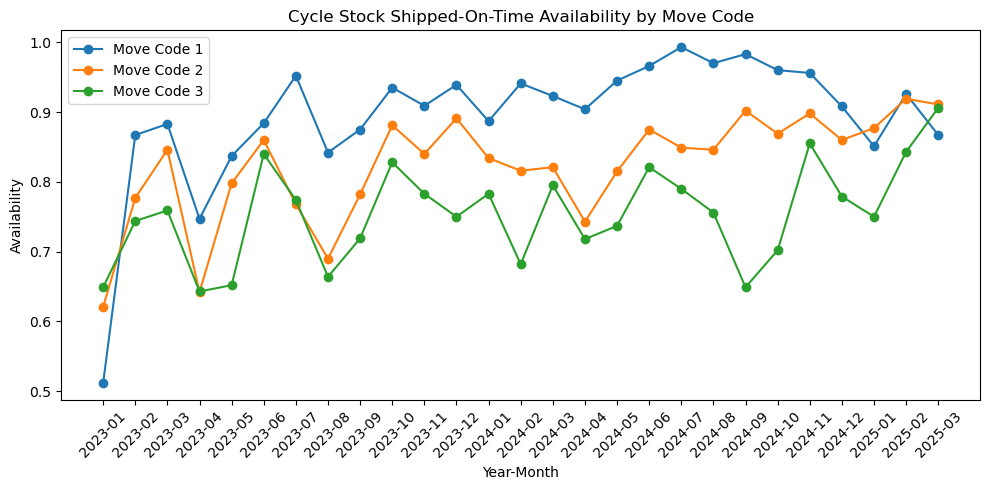

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for mc in availability_pivot.columns:
    plt.plot(
        availability_pivot.index,
        availability_pivot[mc],
        marker="o",
        label=f"Move Code {mc}"
    )

plt.title("Cycle Stock Shipped-On-Time Availability by Move Code")
plt.xlabel("Year-Month")
plt.ylabel("Availability")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


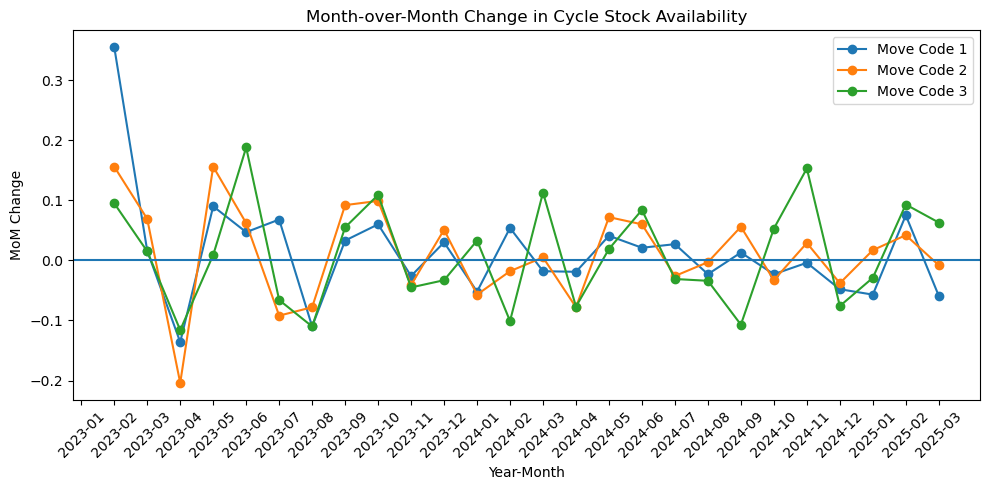

In [19]:
plt.figure(figsize=(10, 5))

for mc in availability_mom_change.columns:
    plt.plot(
        availability_mom_change.index,
        availability_mom_change[mc],
        marker="o",
        label=f"Move Code {mc}"
    )

plt.axhline(0)
plt.title("Month-over-Month Change in Cycle Stock Availability")
plt.xlabel("Year-Month")
plt.ylabel("MoM Change")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


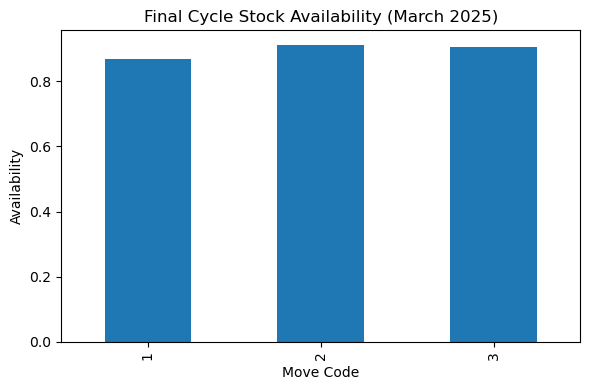

In [20]:
plt.figure(figsize=(6, 4))

final_availability.plot(kind="bar")

plt.title("Final Cycle Stock Availability (March 2025)")
plt.xlabel("Move Code")
plt.ylabel("Availability")
plt.tight_layout()
plt.show()


In [22]:
from pathlib import Path

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

availability_pivot.plot(figsize=(10, 5))
plt.title("Cycle Stock Availability by Move Code")
plt.xlabel("Year-Month")
plt.ylabel("Availability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUT_DIR / "availability_trend.png", dpi=300)
plt.close()

availability_mom_change.plot(figsize=(10, 5))
plt.axhline(0)
plt.title("MoM Change in Cycle Stock Availability")
plt.xlabel("Year-Month")
plt.ylabel("MoM Change")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUT_DIR / "availability_mom.png", dpi=300)
plt.close()


In [23]:
from pathlib import Path

OUT_DIR = Path("../outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

plt.figure()
availability_pivot.plot(figsize=(10, 5))
plt.title("Cycle Stock Availability by Move Code")
plt.xlabel("Year-Month")
plt.ylabel("Availability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUT_DIR / "availability_trend.png", dpi=300)
plt.close()

plt.figure()
availability_mom_change.plot(figsize=(10, 5))
plt.axhline(0)
plt.title("MoM Change in Cycle Stock Availability")
plt.xlabel("Year-Month")
plt.ylabel("MoM Change")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUT_DIR / "availability_mom.png", dpi=300)
plt.close()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
import os
os.getcwd()


'C:\\Users\\Russellko\\Google Drive'

In [26]:
from pathlib import Path

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

OUT_DIR


WindowsPath('outputs')

In [2]:
from pathlib import Path

OUT_DIR = Path("outputs/us")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_DIR


WindowsPath('outputs/us')

In [14]:
import pandas as pd

df_us = pd.read_excel(r"C:\Users\Russellko\Google Drive\US_Parts_Sales_Data_202503.xlsx")

df_us.shape


(26730, 18)

In [15]:
analysis_us = df_us[
    (df_us["wh_dispatch_date"] >= "2023-01-01") &
    (df_us["wh_dispatch_date"] <= "2025-03-31") &
    (df_us["move_code"].isin([1, 2, 3]))
].copy()

analysis_us.shape


(19384, 18)

In [17]:
analysis_us["year_month"] = analysis_us["wh_dispatch_date"].dt.to_period("M").astype(str)

analysis_us[["wh_dispatch_date", "year_month"]].head()


,wh_dispatch_date,year_month
1,2023-01-26,2023-01
3,2023-01-12,2023-01
5,2023-01-17,2023-01
6,2023-01-19,2023-01
7,2023-01-31,2023-01


In [19]:
import pandas as pd

def us_sla_deadline(so_dt: pd.Timestamp) -> pd.Timestamp:
    so_dt = pd.Timestamp(so_dt)
    dow = so_dt.weekday()  # Mon=0 ... Sun=6
    two_pm = so_dt.normalize() + pd.Timedelta(hours=14)

    # Base SLA: 24 hours from SO creation
    deadline = so_dt + pd.Timedelta(hours=24)

    # Thu after 2pm → Monday 2pm
    if dow == 3 and so_dt >= two_pm:
        deadline = (so_dt.normalize() + pd.Timedelta(days=4, hours=14))  # next Monday 2pm

    # Fri (any time) → Monday 2pm
    elif dow == 4:
        deadline = (so_dt.normalize() + pd.Timedelta(days=3, hours=14))  # Monday 2pm

    # Sat/Sun → Monday 2pm
    elif dow == 5:
        deadline = (so_dt.normalize() + pd.Timedelta(days=2, hours=14))  # Monday 2pm
    elif dow == 6:
        deadline = (so_dt.normalize() + pd.Timedelta(days=1, hours=14))  # Monday 2pm

    return deadline

analysis_us["sla_deadline"] = analysis_us["so_creation_date"].apply(us_sla_deadline)
analysis_us["sla_met"] = analysis_us["wh_dispatch_date"] <= analysis_us["sla_deadline"]

analysis_us[["so_creation_date","wh_dispatch_date","sla_deadline","sla_met"]].head()


,so_creation_date,wh_dispatch_date,sla_deadline,sla_met
1,2023-01-26 13:44:02,2023-01-26,2023-01-27 13:44:02,True
3,2023-01-10 08:34:12,2023-01-12,2023-01-11 08:34:12,False
5,2023-01-17 10:59:41,2023-01-17,2023-01-18 10:59:41,True
6,2023-01-19 08:44:51,2023-01-19,2023-01-20 08:44:51,True
7,2023-01-31 11:05:32,2023-01-31,2023-02-01 11:05:32,True


In [20]:
availability_monthly = (
    analysis_us
    .groupby(["year_month", "move_code"])
    .agg(
        total_lines=("sla_met", "count"),
        shipped_on_time=("sla_met", "sum")
    )
    .assign(
        availability_pct=lambda x: x["shipped_on_time"] / x["total_lines"]
    )
    .reset_index()
)

availability_monthly.head()


,year_month,move_code,total_lines,shipped_on_time,availability_pct
0,2023-01,1,330,165,0.500000
1,2023-01,2,103,64,0.621359
2,2023-01,3,74,48,0.648649
3,2023-02,1,332,288,0.867470
4,2023-02,2,103,80,0.776699


In [21]:
cycle_codes = [1, 2, 3]

availability_pivot = (
    availability_monthly
    .query("move_code in @cycle_codes")
    .pivot(index="year_month", columns="move_code", values="availability_pct")
    .sort_index()
    .round(3)
)

availability_pivot.tail()


move_code,1,2,3
year_month,,,
2024-11,0.956,0.898,0.855
2024-12,0.908,0.860,0.779
2025-01,0.851,0.877,0.750
2025-02,0.926,0.919,0.843
2025-03,0.867,0.911,0.906


In [22]:
import matplotlib.pyplot as plt

fig = availability_pivot.plot(figsize=(10, 5)).get_figure()
fig.suptitle("US Cycle Stock Shipped-On-Time Availability by Move Code")
plt.xlabel("Year-Month")
plt.ylabel("Availability")
plt.xticks(rotation=45)
fig.tight_layout()
fig.savefig(OUT_DIR / "availability_trend.png", dpi=300)
plt.close(fig)

"saved", str(OUT_DIR / "availability_trend.png")


('saved', 'outputs\\us\\availability_trend.png')

In [23]:
availability_mom_change = availability_pivot.diff().round(3)

fig = availability_mom_change.plot(figsize=(10, 5)).get_figure()
plt.axhline(0)
fig.suptitle("US Month-over-Month Change in Cycle Stock Availability")
plt.xlabel("Year-Month")
plt.ylabel("MoM Change")
plt.xticks(rotation=45)
fig.tight_layout()
fig.savefig(OUT_DIR / "availability_mom.png", dpi=300)
plt.close(fig)

"saved", str(OUT_DIR / "availability_mom.png")


('saved', 'outputs\\us\\availability_mom.png')